# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


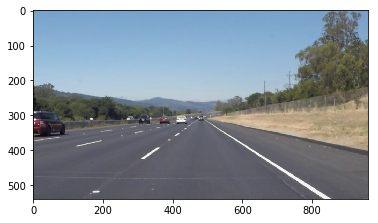

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [156]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    if len(initial_img.shape) <= 2:
        initial_img = cv2.cvtColor(initial_img, cv2.COLOR_GRAY2RGB)
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

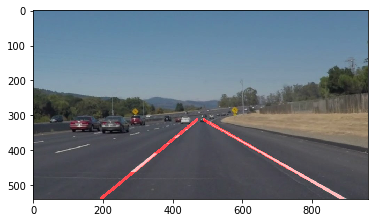

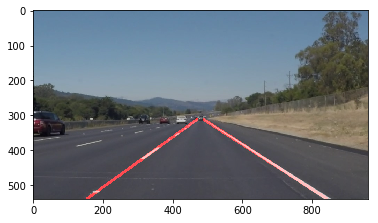

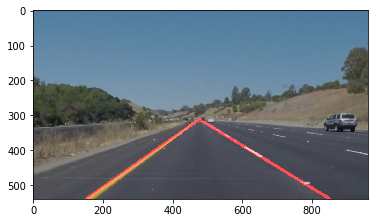

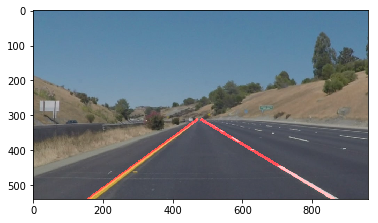

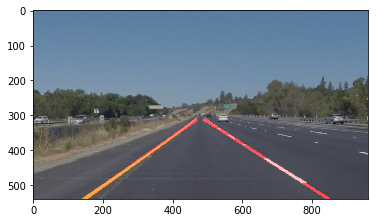

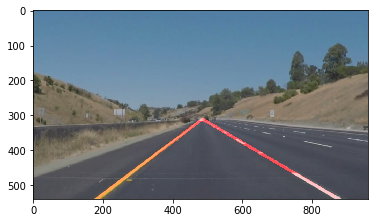

In [585]:
from functools import partial
from collections import OrderedDict


RIGHT = "RIGHT"
LEFT = "LEFT"
DROP = "DROP"
TG_HIGH_THRESHOLD = 1.85
TG_LOW_THRESHOLD = 0.4
EPS = 0.0001


def get_vertical_tg(line):
    x1, y1, x2, y2 = line
    dx = x2 - x1
    dy = y2 - y1
    
    if abs(dy) <= EPS:
        return None
    
    if abs(dx) <= EPS:
        return None
    
    return dx/dy
    

def classify_by_angle(line):   
    tg = get_vertical_tg(line)

    if tg is None:
        return DROP
    
    if (abs(tg) > TG_HIGH_THRESHOLD) or (abs(tg) < TG_LOW_THRESHOLD):
        return DROP
    
    if tg > 0:
        return RIGHT
    return LEFT
    

def classify_by_position(line, width):
    x1, y1, x2, y2 = line
    
    mid_x = width / 2
    
    if (x1 < mid_x) and (x2 < mid_x):
        return LEFT
    
    if (x1 > mid_x) and (x2 > mid_x):
        return RIGHT
    
    return DROP
    
    
def unpack_lines(lines):
    return [tuple(line_arr[0]) for line_arr in lines]


def group_lines_by_lane_side(lines, width):
    left = []
    right = []
    for line in lines:
        what = (classify_by_angle(line), classify_by_position(line, width))
        if what == (LEFT, LEFT):
            left.append(line)
        elif what == (RIGHT, RIGHT):
            right.append(line)
            
    return left, right


def get_mask(image, horizon_height, inset=0):
    height = image.shape[0]
    width = image.shape[1]
    delta = width / 3
    return np.array([[
        (0 + inset, height - inset),
        (width / 2 - delta + inset, horizon_height + inset),
        (width / 2 + delta - inset, horizon_height + inset),
        (width - inset, height - inset)]], dtype=np.int32)

    
def apply_mask(image, horizon_height, inset=0):
    masked = region_of_interest(image, get_mask(image, horizon_height, inset))
    return masked


def get_m_b(line):
    x1, y1, x2, y2 = line
    dy = y2 - y1
    dx = x2 - x1
    m = dy / dx
    b = y1 - m * x1
    return m, b
        
    
def mirror_line_y(line, axis_x):
    x1, y1, x2, y2 = line
    x1_new = x1 - axis_x
    x2_new = x2 - axis_x
    
    x1_new = -x1_new
    x2_new = -x2_new
    
    x1 = x1_new + axis_x
    x2 = x2_new + axis_x
    
    return x1, y1, x2, y2


def mirror_lines_y(lines, axis_x):
    return [mirror_line_y(line, axis_x) for line in lines]


def normalize_group_2(lines, max_y, horizon_y, max_x, top=1, n_buckets=10):
    if not lines:
        return lines
    
    buckets = []
    for i in range(n_buckets):
        buckets.append([])

    candidates = []
    for line in lines:
        x1, y1, x2, y2 = line
        dy = y2 - y1
        dx = x2 - x1
        m = dy / dx
        b = y1 - m * x1
        
        # y = mx + b
        # x = (y-b) / m
        proj_x = (horizon_y - b) / m
        if proj_x > 0 and proj_x < max_x:
            candidates.append((proj_x, line))
            
    
    for proj_x, line in candidates:
        bucket_idx = int(proj_x / (max_x / len(buckets)))
        buckets[bucket_idx].append((proj_x, line))

    buckets = sorted(buckets, key=len, reverse=True)[:top]

    result = []
    for bucket in buckets:
        result += [proj_line[1] for proj_line in bucket]
    return result


def normalize_group_2_left(lines, max_y, horizon_y, max_x):
    return normalize_group_2(lines, max_y, horizon_y, max_x)


def normalize_group_2_right(lines, max_y, horizon_y, max_x):
    mirrored = mirror_lines_y(lines, max_x)
    return mirror_lines_y(normalize_group_2(mirrored, max_y, horizon_y, max_x), max_x)


def normalize_groups_2_both(left_right_lines, max_y, horizon_y, max_x):
    left, right = left_right_lines
    left = normalize_group_2_left(left, max_y, horizon_y, max_x)
    right = normalize_group_2_right(right, max_y, horizon_y, max_x)
    return left, right


def average_lines(lines, max_y, horizon_y):
    if not lines:
        return lines

    sum_m = 0
    sum_b = 0
    for line in lines:
        x1, y1, x2, y2 = line
        m = (y2 - y1) / (x2 - x1)
        sum_m += m
        
        # y - y1 = m*(x - x1)
        # b = y1 - m*x1
        
        b = y1 - m * x1
        sum_b += b
        
    avg_m = sum_m / len(lines)
    avg_b = sum_b / len(lines)
    
    # y = avg_m * x + avg_b
    # x = (y - avg_b) / avg_m
    
    x1 = (horizon_y - avg_b) / avg_m
    x2 = (max_y - avg_b) / avg_m

    return [[x1, horizon_y, x2, max_y]]


def average_lines_both(left_right_lines, horizon_y, max_y):
    left_lines, right_lines = left_right_lines
    left_lines = average_lines(left_lines, max_y, horizon_y)
    right_lines = average_lines(right_lines, max_y, horizon_y)
    return left_lines + right_lines


def run_pipeline(image, pipeline):
    result = OrderedDict([('input', image)])
    for name, func in pipeline.items():
        processed = func(image)
        result[name] = processed
        image = processed
    return result


def do_process_image(image):
    #print('This image is:', type(image), 'with dimesions:', image.shape)
    # This worked with equalized input, but was offsetting lanes on real image
    #gauss_kernel_size = 7
    #canny_low_threshold = 80
    #canny_high_threshold = 250
    #hough_rho = 2              # distance resolution in pixels of the Hough grid
    #hough_theta = np.pi/180    # angular resolution in radians of the Hough grid
    #hough_threshold = 50       # minimum number of votes (intersections in Hough grid cell)
    #hough_min_line_length = 50 # minimum number of pixels making up a line
    #hough_max_line_gap = 50    # maximum gap in pixels between connectable line segments
    #horizon_height_scale = 0.58
    #horizon_scan_scale = 0.7
    
    gauss_kernel_size = 5
    canny_low_threshold = 50
    canny_high_threshold = 150
    hough_rho = 1              # distance resolution in pixels of the Hough grid
    hough_theta = np.pi/180    # angular resolution in radians of the Hough grid
    hough_threshold = 30       # minimum number of votes (intersections in Hough grid cell)
    hough_min_line_length = 30 # minimum number of pixels making up a line
    hough_max_line_gap = 70    # maximum gap in pixels between connectable line segments
    horizon_height_scale = 0.58
    horizon_scan_scale = 0.7
    
    image_height = image.shape[0]
    image_width = image.shape[1]
    horizon_height = horizon_height_scale * image_height

    draw_mask = False
    draw_hough_lines = False
    draw_groupped_lines = False
    draw_lane_lines = True
    what_to_show = 'input'
    
    process_result = run_pipeline(image, OrderedDict([
        ('grayscale', grayscale),
        ('blured', partial(gaussian_blur, kernel_size=gauss_kernel_size)),
        #('mask', partial(apply_mask, horizon_height=horizon_height)),
        #('equalize_hist', cv2.equalizeHist),
        ('canny', partial(canny, low_threshold=canny_low_threshold, high_threshold=canny_high_threshold)),
        ('masked_canny', partial(apply_mask, horizon_height=horizon_height, inset=5)),
        ('hough_lines', partial(cv2.HoughLinesP,
                                rho=hough_rho,
                                theta=hough_theta,
                                threshold=hough_threshold,
                                lines=np.array([]),
                                minLineLength=hough_min_line_length,
                                maxLineGap=hough_max_line_gap)),
        ('unpack_lines', unpack_lines),
        ('group_lines', partial(group_lines_by_lane_side, width=image.shape[1])),
        ('elect_best', partial(normalize_groups_2_both,
                               max_y=image_height-1,
                               horizon_y=horizon_scan_scale * image_height,
                               max_x=image_width/2)),
        ('average_lines_both', partial(average_lines_both,
                                       horizon_y=horizon_height,
                                       max_y=image_height-1))
    ]))
    
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    if draw_mask:
        cv2.fillPoly(line_img, get_mask(image, horizon_height), [0., 255., 0.])
    
    # Draw hough lines:
    if draw_hough_lines:
        draw_lines(line_img, np.array(process_result['hough_lines'], dtype=np.int32),
                   thickness=3, color=[0., 0., 255.])

    # Draw groupped lines
    if draw_groupped_lines:
        draw_lines(line_img,
                   np.array([process_result['group_lines'][1]], dtype=np.int32),
                   thickness=5, color=[0., 0., 255.])
        draw_lines(line_img,
                   np.array([process_result['group_lines'][0]], dtype=np.int32),
                   thickness=5, color=[0., 255., 0.])
        
    if draw_lane_lines:
        draw_lines(line_img, np.array([process_result['average_lines_both']], dtype=np.int32), thickness=8)

    result = weighted_img(line_img, process_result[what_to_show])
    return result


for image_name in os.listdir("test_images/"):
    image = mpimg.imread(os.path.join('test_images', image_name))
    plt.figure()
    # TODO: write into file???
    plt.imshow(do_process_image(image), cmap='gray')


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [334]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [540]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = do_process_image(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [579]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 72.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.61 s, sys: 752 ms, total: 3.36 s
Wall time: 3.52 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [580]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [581]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:10<00:00, 67.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 8.67 s, sys: 1.8 s, total: 10.5 s
Wall time: 10.6 s


In [582]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

There are multiple challenges with the lane detection pipeline that was implemented. It had multiple dials that can be used to adjust its performance on the input data, and they were adjusted to perform well on the data stream that does not have enough variety - all frames that were tested are in a well-lit perfect highways with a good contrast between the highway and markings. Lack of variety indicates that the chances that the pipeline is biased are very high. Here is a number of things that the pipeline was adjusted to:

1. Position and resolution of the camera. The stage that does the masking has specific assumptions on what is the size of the image, where the horizon is.

2. Image contrast. It is quite probable that during the cloudy weather conditions, the low and high thresholds for the canny algorithm would need to be adjusted to produce more data points.

3. Probabilistic Hough Line Transformation works very well on solid lines on the side of a road, but for dashed lines that separate the lanes, adjustments were made to consider shorter lines as good ones, and this can produce noisy input for the next stages.

4. Initial approach to just group lane lines by angle and the average position was not enough, as results of Hough Transformation was producing noisy lines and they were offsetting average coordinates. As a result, it was required to do additional classification by dividing the image vertically in halves and considering left and right separately.

Here is where the algorithm would quite probably fail:

1. It will not work with curved markup, like on a roundabout, as it is just projecting straight lines.

2. It will probably be not suitable for the rainy weather conditions, due to the noise produced by water drops on the road.

3. Changing lanes would confuse algorithm, as it has strict knowledge now that left line of the lane should be on the left.

It would be nice to automate discovery of the coefficients for the image processing and try to apply machine learning algorithms to classify the lines and probably partition the image into the left and right side of the lane to accomodate lane switching periods.

Another challenge was to implement lane side classification due to perspective projection. Probably some noise can be eliminated by unprojecting it first, so that vertical would have straight angle.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [583]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:08<00:00, 29.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.86 s, sys: 1.58 s, total: 8.43 s
Wall time: 9.17 s


In [584]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))